# Étude de la classe car following

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.309 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Fonction utiles et imports nécessaires

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [4]:
from dtw import *
import matplotlib.pyplot as plt
from datetime import timedelta

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            #M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
            M[i,j] = sqrt((X_veh[i]-X_ego[j])**2+(Y_veh[i]-Y_ego[j])**2)
    return M 
     

In [6]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances entre 
# les pts qui interagissent dans le temps 

def M_distance_time(X_ego,Y_ego,T_ego,X_veh,Y_veh,T_veh):
    
    debut = max(T_ego[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_ego[len(T_ego)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_ego)):
        if debut<=T_ego[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    M = np.zeros((len(L_indice_veh),len(L_indice_ego)))
    for i in range(0,len(L_indice_veh)):
        for j in range(0,len(L_indice_ego)):
            M[i,j] = sqrt((X_veh[L_indice_veh[i]]-X_ego[L_indice_ego[j]])**2+(Y_veh[L_indice_veh[i]]-Y_ego[L_indice_ego[j]])**2)
    
    return M 

In [7]:
# Pour normaliser le calcul de DTW, on va créer une fonction qui calcule
# la distance parcourue par un véhicule au cours de la scène, en prenant
# en entrée ses coordonnées

def distance_parcourue(X,Y,Z):
    D =[0]
    for k in range(0,len(X)-1):
        d = D[k]+ sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2+(Z[k+1]-Z[k])**2)
        D.append(d)
    return D[len(D)-1]

#### Fenêtre glissante

In [8]:
## Fonction qui renvoie une dataframe avec les valeurs de dtw calculés sur des intervalles de temps d'une seconde : 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_glissante(scene_name):
    
    # On crée une dataframe 
    df = pd.DataFrame()
    L_intervalle = [[k,k+1] for k in range(0,20)]
    df['index']= L_intervalle
    df.set_index('index',inplace=True)
    df.index.name = None
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        if len(X_mobile)>0:
        
            for i in range(0,len(X_mobile)):
            
                L_df = []
                # On fait une boucle sur les intervalles de temps 
                for k in range(0,20):
                    current_intervalle = [k,k+1]
                    # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                    Lx_pt_veh = []
                    Ly_pt_veh = []
                    Lt_pt_veh = []
                    Lx_pt_ego = []
                    Ly_pt_ego = []
                    Lt_pt_ego = []
                
                    # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                    for s in range(len(X_mobile[i])):
                        tveh = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tveh <= current_intervalle[1] and tveh >= current_intervalle[0] :
                            Lx_pt_veh.append(X_mobile[i][s])
                            Ly_pt_veh.append(Y_mobile[i][s])
                            Lt_pt_veh.append(T_mobile[i][s])
                    
                
                
                    # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                    for s in range(len(X_coord)):
                        tego = (datetime.datetime.fromtimestamp(T_timestamp[s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tego <= current_intervalle[1] and tego >= current_intervalle[0]:
                            Lx_pt_ego.append(X_coord[s])
                            Ly_pt_ego.append(Y_coord[s])
                            Lt_pt_ego.append(T_timestamp[s])
                
                            
                    if len(Lx_pt_veh)==0:
                        L_df.append(np.nan)
                    else :
                        #M_distance = M_distance_time(Lx_pt_ego,Ly_pt_ego,Lt_pt_ego,Lx_pt_veh,Ly_pt_veh,Lt_pt_veh)
                        M_distance = Matrice_distance(Lx_pt_ego,Ly_pt_ego,Lx_pt_veh,Ly_pt_veh)
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_df.append(distance) 


                nom = catego_name +' '+str(i+1)
                df[nom]= L_df
    
    return df

#M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])

#### Produit scalaire entre les vecteurs

In [9]:
# Fonction qui renvoie la matrice des produits scalaires
import numpy as np

def Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
        
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
        
    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.dot(V[i],V_ego[j])/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [10]:
# Fonction qui renvoie la norme du produit vectoriel divisée par la norme des vecteurs

def Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
         
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)

    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.linalg.norm(np.cross(V[i],V_ego[j]))/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [11]:
# Fonction qui renvoie la vitesse moyenne de deux véhicules pendant le temps où ils interagissent 

def vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
    # Il faut créer le vecteur des normes de V_ego qui contient lui que des vecteurs 
    v_ego_moy = np.mean([np.linalg.norm(V_ego[i]) for i in range(0,len(V_ego))])
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
    v_veh_moy = np.mean([np.linalg.norm(V[i]) for i in range(0,len(V))])
        
    return v_ego_moy,v_veh_moy

### Création des dataframes contenant les indicateurs 

In [12]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
    # Les lignes en plus : 'Time log moyen'
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None
    
    # Dataframe des fenêtre glissantes 
    df_glissante = dtw_glissante(scene_name) 
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            L_objet = [] 
            # nom du véhicule 
            nom = catego_name +' '+str(i+1)
            
            ## Scene 
            L_objet.append(scene_name)
            
            ## Catégorie Véhicule 1
            L_objet.append('vehicle.ego')
            
            ## Numéro véhicule 1
            L_objet.append(1)
        
            ## Catégoie Véhicule 2
            L_objet.append(catego_name)
            
            ## Catégoie Véhicule 2
            L_objet.append(i+1)
            
            ## Vitesses moyennes 
            v_moy_ego, v_moy_veh = vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_objet.append(v_moy_ego)
            L_objet.append(v_moy_veh)
            
            ## Durée d'interaction 
            debut = max(T_mobile[i][0],T_timestamp[0])
            fin = min(T_mobile[i][-1],T_timestamp[-1])
            temps_ego = (datetime.datetime.fromtimestamp(T_timestamp[-1]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
            L_objet.append(t_total/temps_ego)
            #L_objet.append(t_total)
            
            ## DTW normalisée
            #M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            L_objet.append(distance)
            
            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
            
            ## Distance instannée moyenne 
            L_objet.append(df_glissante[nom].mean())
            
            ## Distance instannée minimale
            L_objet.append(df_glissante[nom].min())
            
            ## Distance instannée maximale
            L_objet.append(df_glissante[nom].max())
            
            ## Time log moyen horizontal
            recurrence_0 = list(alignment.index1).count(0)
            indice_max_ego = alignment.index2[recurrence_0-1]
            t_horizontal = (datetime.datetime.fromtimestamp(T_timestamp[indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            L_objet.append(t_horizontal)
            
            ## Time log moyen vertical
            N = max(alignment.index2)
            recurrence_N = list(alignment.index2).count(N)
            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
            t_vertical = (datetime.datetime.fromtimestamp(T_mobile[i][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][indice_min_veh]/ 1e6)).total_seconds()
            L_objet.append(t_vertical)
            
            ## Indicateur d'orthogonalité moyen : sin 
            M_pv = Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_pv))
            
            ## Indicateur d'orthogonalité min 
            L_objet.append(min(L_pv))
            
            ## Indicateur d'orthogonalité max
            L_objet.append(max(L_pv))
            
            ## Indicateur de colinéarité moyen : cos
            M_ps = Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_ps))
            
            ## Indicateur de colinéarité min
            L_objet.append(min(L_ps))
            
            ## Indicateur de colinéarité max
            L_objet.append(max(L_ps))
            
            ## Sens 
            if mean(L_ps)>0:
                L_objet.append(1)
            else :
                L_objet.append(0)

            ## Distance min dans la matrice 
            L_objet.append(M_distance.min())
            
            ## Distance max dans la matrice 
            L_objet.append(M_distance.max()) 
            
            ## Distance moyenne dans la matrice 
            L_objet.append(M_distance.mean()) 
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            df[nom]=L_objet
    return df.transpose()
    

#### On étend le calcul à une l'étude des interractions entre les véhicules 

In [13]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
   
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None 

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    L_objet = [] 
                    # nom du véhicule 
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ## Scene_name
                    L_objet.append(scene_name)
                    
                    ## Catégorie Véhicule 1 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 1 
                    L_objet.append(i+1)
                    
                    ## Catégorie Véhicule 2 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 2 
                    L_objet.append(k+1)
                    
                    ## Vitesses moyennes 
                    v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    L_objet.append(v_moy_veh1)
                    L_objet.append(v_moy_veh2)
                    
                    ## Durée d'interaction 
                    debut = max(T_mobile[i][0],T_mobile[k][0])
                    fin = min(T_mobile[i][-1],T_mobile[k][-1])
                    t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                    temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T_mobile[k][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][0]/ 1e6)).total_seconds())
                    if t_total >0 :
                        L_objet.append(t_total/temps_max)
                        #L_objet.append(t_total)
                    else :
                        L_objet.append(np.nan)
                        

                    ## DTW normalisée
                    M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    
                    if len(M_distance)>0 :
                    
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_objet.append(distance)

                        Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                        ### Fenêtre glissante 

                        L_df = []
                        # On fait une boucle sur les intervalles de temps 
                        for m in range(0,20):
                            current_intervalle = [m,m+1]
                            # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                            Lx_pt_veh1 = []
                            Ly_pt_veh1 = []
                            Lt_pt_veh1 = []
                            Lx_pt_veh2 = []
                            Ly_pt_veh2 = []
                            Lt_pt_veh2 = []

                            # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[i])):
                                tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                    Lx_pt_veh1.append(X_mobile[i][s])
                                    Ly_pt_veh1.append(Y_mobile[i][s])
                                    Lt_pt_veh1.append(T_mobile[i][s])

                            # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[k])):
                                tveh2 = (datetime.datetime.fromtimestamp(T_mobile[k][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                    Lx_pt_veh2.append(X_mobile[k][s])
                                    Ly_pt_veh2.append(Y_mobile[k][s])
                                    Lt_pt_veh2.append(T_mobile[k][s])

                            if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                alignment_glissante = dtw(M_distance_glissante)
                                distance_glissante = alignment_glissante.normalizedDistance
                                L_df.append(distance_glissante) 

                        ## Distance instannée moyenne 
                        L_objet.append(mean(L_df))

                        ## Distance instannée minimale
                        L_objet.append(min(L_df))

                        ## Distance instannée maximale
                        L_objet.append(max(L_df))

                        ## Time log moyen horizontal
                        recurrence_0 = list(alignment.index1).count(0)
                        indice_max_ego = alignment.index2[recurrence_0-1]
                        t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                        L_objet.append(t_horizontal)

                        ## Time log moyen vertical
                        N = max(alignment.index2)
                        recurrence_N = list(alignment.index2).count(N)
                        indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                        t_vertical = (datetime.datetime.fromtimestamp(T_mobile[k][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][indice_min_veh]/ 1e6)).total_seconds()
                        L_objet.append(t_vertical)

                        ## Indicateur d'orthogonalité : sin 
                        M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_pv)>0:
                            L_objet.append(mean(L_pv))
                            L_objet.append(min(L_pv))
                            L_objet.append(max(L_pv))
                        else :
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)

                        ## Indicateur de colinéarité : cos
                        M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_ps)>0:
                            L_objet.append(mean(L_ps))
                            L_objet.append(min(L_ps))
                            L_objet.append(max(L_ps))
                        else : 
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                        
                        ## Sens :
                        if len(L_ps)>0 :
                            if mean(L_ps)>0:
                                L_objet.append(1)
                            else :
                                L_objet.append(0)
                        else : 
                            L_objet.append(np.nan)
        
                        ## Distance min dans la matrice 
                        L_objet.append(M_distance.min())

                        ## Distance max dans la matrice 
                        L_objet.append(M_distance.max()) 

                        ## Distance moyenne dans la matrice 
                        L_objet.append(M_distance.mean()) 
                    
                    else : 
                        L_objet = L_objet + [np.nan]*16
                        
                    df[nom]=L_objet
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        L_objet = [] 
                        # nom du véhicule 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name

                        ## Scene_name
                        L_objet.append(scene_name)
                        
                         ## Catégorie Véhicule 1 
                        L_objet.append(catego_name)
                        ## Numéro véhicule 1 
                        L_objet.append(i+1)
                    
                        ## Catégorie Véhicule 2 
                        L_objet.append(catego_name2)
                        ## Numéro véhicule 2 
                        L_objet.append(n+1)

                        ## Vitesses moyennes 
                        v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                        L_objet.append(v_moy_veh1)
                        L_objet.append(v_moy_veh2)

                        ## Durée d'interaction 
                        debut = max(T_mobile[i][0],T2_mobile[n][0])
                        fin = min(T_mobile[i][-1],T2_mobile[n][-1])
                        t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                        temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T2_mobile[n][-1]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][0]/ 1e6)).total_seconds())
                        if t_total >0 :
                            L_objet.append(t_total/temps_max)
                            #L_objet.append(t_total)
                        else :
                            L_objet.append(np.nan)


                        ## DTW normalisée
                        M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])

                        if len(M_distance)>0 :

                            alignment = dtw(M_distance)
                            distance = alignment.normalizedDistance
                            L_objet.append(distance)

                            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                            ### Fenêtre glissante 

                            L_df = []
                            # On fait une boucle sur les intervalles de temps 
                            for m in range(0,20):
                                current_intervalle = [m,m+1]
                                # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                                Lx_pt_veh1 = []
                                Ly_pt_veh1 = []
                                Lt_pt_veh1 = []
                                Lx_pt_veh2 = []
                                Ly_pt_veh2 = []
                                Lt_pt_veh2 = []

                                # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                                for s in range(len(X_mobile[i])):
                                    tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                        Lx_pt_veh1.append(X_mobile[i][s])
                                        Ly_pt_veh1.append(Y_mobile[i][s])
                                        Lt_pt_veh1.append(T_mobile[i][s])

                                # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                                for s in range(len(X2_mobile[n])):
                                    tveh2 = (datetime.datetime.fromtimestamp(T2_mobile[n][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                        Lx_pt_veh2.append(X2_mobile[n][s])
                                        Ly_pt_veh2.append(Y2_mobile[n][s])
                                        Lt_pt_veh2.append(T2_mobile[n][s])

                                if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                    #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                    M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                    alignment_glissante = dtw(M_distance_glissante)
                                    distance_glissante = alignment_glissante.normalizedDistance
                                    L_df.append(distance_glissante) 

                            ## Distance instannée moyenne 
                            L_objet.append(mean(L_df))

                            ## Distance instannée minimale
                            L_objet.append(min(L_df))

                            ## Distance instannée maximale
                            L_objet.append(max(L_df))

                            ## Time log moyen horizontal
                            recurrence_0 = list(alignment.index1).count(0)
                            indice_max_ego = alignment.index2[recurrence_0-1]
                            t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                            L_objet.append(t_horizontal)

                            ## Time log moyen vertical
                            N = max(alignment.index2)
                            recurrence_N = list(alignment.index2).count(N)
                            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                            t_vertical = (datetime.datetime.fromtimestamp(T2_mobile[n][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][indice_min_veh]/ 1e6)).total_seconds()
                            L_objet.append(t_vertical)

                            ## Indicateur d'orthogonalité : sin 
                            M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_pv)>0:
                                L_objet.append(mean(L_pv))
                                L_objet.append(min(L_pv))
                                L_objet.append(max(L_pv))
                            else :
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)

                            ## Indicateur de colinéarité : cos
                            M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_ps)>0:
                                L_objet.append(mean(L_ps))
                                L_objet.append(min(L_ps))
                                L_objet.append(max(L_ps))
                            else : 
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                
                            ## Sens :
                            if len(L_ps)>0 :
                                if mean(L_ps)>0:
                                    L_objet.append(1)
                                else :
                                    L_objet.append(0)
                            else : 
                                L_objet.append(np.nan)

                            ## Distance min dans la matrice 
                            L_objet.append(M_distance.min())

                            ## Distance max dans la matrice 
                            L_objet.append(M_distance.max()) 

                            ## Distance moyenne dans la matrice 
                            L_objet.append(M_distance.mean()) 

                        else : 
                            L_objet = L_objet + [np.nan]*16

                        df[nom]=L_objet

    return df.transpose()

### Dataframe finale 

In [14]:
## Dataframe contenant toutes les données pour tous les couples de trajectoires à l'intérieur des 10 scènes 

In [15]:
import time
debut = time.time()
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego = pd.concat([indicateur_similarite(scene_name) for scene_name in L_scene_name])
df_entre_veh = pd.concat([indicateur_similarite_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale = pd.concat([df_ego,df_entre_veh])
print(time.time()-debut)
#%time

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


42.613718032836914


In [16]:
DF_finale

,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.bus.rigid,1,8.564618,9.255912,0.107044,62.784244,72.53295,...,0.011213,0.000274,0.03069,-0.999907,-1.0,-0.999529,0,53.479254,89.795179,71.922482
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,1,8.862925,9.459852,0.054837,24.953401,32.364935,...,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,0,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,2,6.155384,5.78235,0.600504,15.844434,26.217761,...,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,1,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,3,8.564618,11.088804,0.107044,32.294648,38.263151,...,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,1,23.975892,64.147662,43.973192
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,4,4.77538,3.222342,1.0,5.050621,14.823187,...,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,1,0.037589,77.803221,25.983685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,1,10.122451,6.338455,0.384567,49.083647,46.260902,...,0.991064,0.983084,0.999991,0.12377,0.00419,0.183158,1,30.3152,104.29712,64.656899
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,2,10.122451,11.181889,0.750012,12.551868,29.181995,...,0.014729,0.001593,0.041305,0.999805,0.999147,0.999999,1,0.49852,122.125142,46.623162
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,1,1.161951,2.08155,0.666705,53.649857,41.041228,...,NaN,NaN,NaN,NaN,NaN,NaN,0,47.61365,78.469695,55.41502
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,2,3.024676,10.319906,0.269163,22.700355,22.612802,...,0.159685,0.014357,0.248427,-0.981828,-0.999897,-0.968651,0,11.473515,51.084325,28.863618


### Headway spatiale

In [17]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def ego_headway_spatial(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    # On crée les listes vides que l'on va mettre dans df 
    L_couples = []
    L_scene = []
    L_timestamp = []
    L_temps = []
    L_headway = []
    L_vitesse_veh_ego = []
    L_vitesse_veh = []

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            
            ### On s'occupe de créer la liste des éléments en même temps
            debut = max(T_timestamp[0],T_mobile[i][0]) # Temps début detection 
            fin = min(T_timestamp[-1],T_mobile[i][-1]) # Temps fin detection 

            # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
            L_indice_ego = []
            for k in range(0,len(T_timestamp)):
                if debut<=T_timestamp[k]<=fin:
                    L_indice_ego.append(k)

            # Pareil pour le veh 
            L_indice_veh = []
            for k in range(0,len(T_mobile[i])):
                if debut<=T_mobile[i][k]<=fin:
                    L_indice_veh.append(k)
                    
            # On parcourt chaque point
            for k in range(0,len(L_indice_veh)):
                L_couples.append(nom) # Nom du couple 
                L_scene.append(scene_name) # Nom de la scène 
                
                current_time = T_mobile[i][L_indice_veh[k]] # On prend le temps du véhicule 
                L_timestamp.append(current_time)
                
                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                L_temps.append(t)
                
                indice_ego = T_timestamp.index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                d = sqrt((X_coord[indice_ego]-X_mobile[i][L_indice_veh[k]])**2+(Y_coord[indice_ego]-Y_mobile[i][L_indice_veh[k]])**2)
                L_headway.append(d)
                
                if L_indice_veh[k]==len(T_mobile[i])-1 and indice_ego == len(T_timestamp)-1: #Si on est au bout dans les deux cas, on peut pas calculer de vitesses instannées
                    L_vitesse_veh.append(np.nan)
                    L_vitesse_veh_ego.append(np.nan)
                elif L_indice_veh[k]==len(T_mobile[i])-1 and indice_ego != len(T_timestamp)-1:#Si on est au bout que pour le veh 
                    # Pour le véhicule on a rien
                    L_vitesse_veh.append(np.nan)
                    # Pour le véhicule ego, on peut calculer une vitesse
                    t2 = datetime.datetime.fromtimestamp(T_timestamp[indice_ego+1]/ 1e6)
                    t1 = datetime.datetime.fromtimestamp(T_timestamp[indice_ego]/ 1e6)
                    t = (t2-t1).total_seconds()
                    v = np.array([X_coord[indice_ego+1]-X_coord[indice_ego],Y_coord[indice_ego+1]-Y_coord[indice_ego]])/t # Le vecteur a pour norme la vitesse à l'instant k
                    L_vitesse_veh_ego.append(np.linalg.norm(v))
                else :
                    # Pour le véhicule 
                    t2_veh = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh[k]+1]/ 1e6)
                    t1_veh = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh[k]]/ 1e6)
                    t_veh = (t2_veh-t1_veh).total_seconds()
                    v_veh = np.array([X_mobile[i][L_indice_veh[k]+1]-X_mobile[i][L_indice_veh[k]],Y_mobile[i][L_indice_veh[k]+1]-Y_mobile[i][L_indice_veh[k]]])/t_veh
                    L_vitesse_veh.append(np.linalg.norm(v_veh))
                    
                    # Pour le véhicule ego 
                    t2_ego = datetime.datetime.fromtimestamp(T_timestamp[indice_ego+1]/ 1e6)
                    t1_ego = datetime.datetime.fromtimestamp(T_timestamp[indice_ego]/ 1e6)
                    t_ego = (t2_ego-t1_ego).total_seconds()
                    v_ego = np.array([X_coord[indice_ego+1]-X_coord[indice_ego],Y_coord[indice_ego+1]-Y_coord[indice_ego]])/t_ego # Le vecteur a pour norme la vitesse à l'instant k
                    L_vitesse_veh_ego.append(np.linalg.norm(v_ego))        
                    
    df["Couple individus"]=L_couples
    df['Scene']=L_scene
    df['Timestamp']=L_timestamp
    df['Temps correspondant'] = L_temps
    df['Headway']=L_headway
    df['Vitesse véhicule 1 ou ego'] = L_vitesse_veh_ego
    df['Vitesse véhicule 2'] = L_vitesse_veh

    return df

In [18]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def headway_spatial_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    # On crée les listes vides que l'on va mettre dans df 
    L_couples = []
    L_scene = []
    L_timestamp = []
    L_temps = []
    L_headway = []
    L_vitesse_veh1 = []
    L_vitesse_veh2 = []

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    # nom du couple
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ### On s'occupe de créer la liste des éléments en même temps
                    debut = max(T_mobile[k][0],T_mobile[i][0]) # Temps début detection 
                    fin = min(T_mobile[k][-1],T_mobile[i][-1]) # Temps fin detection 

                    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
                    L_indice_veh1 = []
                    for s in range(0,len(T_mobile[i])):
                        if debut<=T_mobile[i][s]<=fin:
                            L_indice_veh1.append(s)

                    # Pareil pour le veh 
                    L_indice_veh2 = []
                    for s in range(0,len(T_mobile[k])):
                        if debut<=T_mobile[k][s]<=fin:
                            L_indice_veh2.append(s)
                            
                    if len(L_indice_veh1)>0 :
                        
                        if len(L_indice_veh1)>len(L_indice_veh2):
                            
                            # On parcourt chaque point de la liste qui en a le moins
                            for s in range(0,len(L_indice_veh2)):
                                L_couples.append(nom) # Nom du couple 
                                L_scene.append(scene_name) # Nom de la scène 

                                current_time = T_mobile[k][L_indice_veh2[s]] # On prend le temps du véhicule 
                                L_timestamp.append(current_time)

                                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                L_temps.append(t)

                                indice_veh1 = T_mobile[i].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                d = sqrt((X_mobile[i][indice_veh1]-X_mobile[k][L_indice_veh2[s]])**2+(Y_mobile[i][indice_veh1]-Y_mobile[k][L_indice_veh2[s]])**2)
                                L_headway.append(d)

                                
                                if L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] == len(T_mobile[k])-1: #Si on est au bout dans les deux cas, on peut pas calculer de vitesses instannée
                                    L_vitesse_veh1.append(np.nan)
                                    L_vitesse_veh2.append(np.nan)
                                elif L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] != len(T_mobile[k])-1 :#Si on est au bout que pour le veh1
                                    # Pour le véhicule1 on a rien
                                    L_vitesse_veh1.append(np.nan)
                                    # Pour le véhicule 2, on peut calculer une vitesse
                                    t2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]+1]/ 1e6)
                                    t1 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]]/ 1e6)
                                    t = (t2-t1).total_seconds()
                                    v = np.array([X_mobile[k][L_indice_veh2[s]+1]-X_mobile[k][L_indice_veh2[s]],Y_mobile[k][L_indice_veh2[s]+1]-Y_mobile[k][L_indice_veh2[s]]])/t
                                    L_vitesse_veh2.append(np.linalg.norm(v))
                                elif L_indice_veh1[s]!=len(T_mobile[i])-1 and L_indice_veh2[s] == len(T_mobile[k])-1 :#Si on est au bout que pour le veh2
                                    # Pour le véhicule2 on a rien
                                    L_vitesse_veh2.append(np.nan)
                                    # Pour le véhicule 1, on peut calculer une vitesse
                                    t2 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                    t1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                    t = (t2-t1).total_seconds()
                                    v = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t
                                    L_vitesse_veh1.append(np.linalg.norm(v))
                                                    
                                else:
                                    # Pour le véhicule 1
                                    t2_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                    t1_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                    t_veh1 = (t2_veh1-t1_veh1).total_seconds()
                                    v_veh1 = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t_veh1
                                    L_vitesse_veh1.append(np.linalg.norm(v_veh1))

                                    # Pour le véhicule 2
                                    t2_veh2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]+1]/ 1e6)
                                    t1_veh2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]]/ 1e6)
                                    t_veh2 = (t2_veh2-t1_veh2).total_seconds()
                                    v_veh2 = np.array([X_mobile[k][L_indice_veh2[s]+1]-X_mobile[k][L_indice_veh2[s]],Y_mobile[k][L_indice_veh2[s]+1]-Y_mobile[k][L_indice_veh2[s]]])/t_veh2
                                    L_vitesse_veh2.append(np.linalg.norm(v_veh2))
     
                        else :
                            # On parcourt chaque point de la liste qui en a le moins
                            for s in range(0,len(L_indice_veh1)):
                                L_couples.append(nom) # Nom du couple 
                                L_scene.append(scene_name) # Nom de la scène 

                                current_time = T_mobile[i][L_indice_veh1[s]] # On prend le temps du véhicule 
                                L_timestamp.append(current_time)

                                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                L_temps.append(t)

                                indice_veh2 = T_mobile[k].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                d = sqrt((X_mobile[k][indice_veh2]-X_mobile[i][L_indice_veh1[s]])**2+(Y_mobile[k][indice_veh2]-Y_mobile[i][L_indice_veh1[s]])**2)
                                L_headway.append(d) 
                                
                                if L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] == len(T_mobile[k])-1: #Si on est au bout dans les deux cas, on peut pas calculer de vitesses instannées
                                    L_vitesse_veh1.append(np.nan)
                                    L_vitesse_veh2.append(np.nan)
                                elif L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] != len(T_mobile[k])-1:#Si on est au bout que pour le veh1
                                    # Pour le véhicule1 on a rien
                                    L_vitesse_veh1.append(np.nan)
                                    # Pour le véhicule 2, on peut calculer une vitesse
                                    t2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]+1]/ 1e6)
                                    t1 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]]/ 1e6)
                                    t = (t2-t1).total_seconds()
                                    v = np.array([X_mobile[k][L_indice_veh2[s]+1]-X_mobile[k][L_indice_veh2[s]],Y_mobile[k][L_indice_veh2[s]+1]-Y_mobile[k][L_indice_veh2[s]]])/t
                                    L_vitesse_veh2.append(np.linalg.norm(v))
                                elif L_indice_veh1[s]!=len(T_mobile[i])-1 and L_indice_veh2[s] == len(T_mobile[k])-1:#Si on est au bout que pour le veh2
                                     # Pour le véhicule2 on a rien
                                    L_vitesse_veh2.append(np.nan)
                                    # Pour le véhicule 1, on peut calculer une vitesse
                                    t2 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                    t1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                    t = (t2-t1).total_seconds()
                                    v = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t
                                    L_vitesse_veh1.append(np.linalg.norm(v))
                                else :
                                    # Pour le véhicule 1
                                    t2_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                    t1_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                    t_veh1 = (t2_veh1-t1_veh1).total_seconds()
                                    v_veh1 = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t_veh1
                                    L_vitesse_veh1.append(np.linalg.norm(v_veh1))

                                    # Pour le véhicule 2
                                    t2_veh2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]+1]/ 1e6)
                                    t1_veh2 = datetime.datetime.fromtimestamp(T_mobile[k][L_indice_veh2[s]]/ 1e6)
                                    t_veh2 = (t2_veh2-t1_veh2).total_seconds()
                                    v_veh2 = np.array([X_mobile[k][L_indice_veh2[s]+1]-X_mobile[k][L_indice_veh2[s]],Y_mobile[k][L_indice_veh2[s]+1]-Y_mobile[k][L_indice_veh2[s]]])/t_veh2
                                    L_vitesse_veh2.append(np.linalg.norm(v_veh2))
    
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name
    
                        ### On s'occupe de créer la liste des éléments en même temps
                        debut = max(T2_mobile[n][0],T_mobile[i][0]) # Temps début detection 
                        fin = min(T2_mobile[n][-1],T_mobile[i][-1]) # Temps fin detection 

                        # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
                        L_indice_veh1 = []
                        for s in range(0,len(T_mobile[i])):
                            if debut<=T_mobile[i][s]<=fin:
                                L_indice_veh1.append(s)

                        # Pareil pour le veh 
                        L_indice_veh2 = []
                        for s in range(0,len(T2_mobile[n])):
                            if debut<=T2_mobile[n][s]<=fin:
                                L_indice_veh2.append(s)

                        if len(L_indice_veh1)>0 :

                            if len(L_indice_veh1)>len(L_indice_veh2):

                                # On parcourt chaque point de la liste qui en a le moins
                                for s in range(0,len(L_indice_veh2)):
                                    L_couples.append(nom) # Nom du couple 
                                    L_scene.append(scene_name) # Nom de la scène 

                                    current_time = T2_mobile[k][L_indice_veh2[s]] # On prend le temps du véhicule 
                                    L_timestamp.append(current_time)

                                    t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    L_temps.append(t)

                                    indice_veh1 = T_mobile[i].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                    d = sqrt((X_mobile[i][indice_veh1]-X2_mobile[n][L_indice_veh2[s]])**2+(Y_mobile[i][indice_veh1]-Y2_mobile[n][L_indice_veh2[s]])**2)
                                    L_headway.append(d)
                                    
                                    if L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] == len(T2_mobile[n])-1: #Si on est au bout dans les deux cas, on peut pas calculer de vitesses instannées
                                        L_vitesse_veh1.append(np.nan)
                                        L_vitesse_veh2.append(np.nan)
                                    elif L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] != len(T2_mobile[n])-1:#Si on est au bout que pour le veh1
                                        # Pour le véhicule1 on a rien
                                        L_vitesse_veh1.append(np.nan)
                                        # Pour le véhicule 2, on peut calculer une vitesse
                                        t2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]+1]/ 1e6)
                                        t1 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]]/ 1e6)
                                        t = (t2-t1).total_seconds()
                                        v = np.array([X2_mobile[n][L_indice_veh2[s]+1]-X2_mobile[n][L_indice_veh2[s]],Y2_mobile[n][L_indice_veh2[s]+1]-Y2_mobile[n][L_indice_veh2[s]]])/t
                                        L_vitesse_veh2.append(np.linalg.norm(v))
                                    elif L_indice_veh1[s]!=len(T_mobile[i])-1 and L_indice_veh2[s] == len(T2_mobile[n])-1:#Si on est au bout que pour le veh2
                                         # Pour le véhicule2 on a rien
                                        L_vitesse_veh2.append(np.nan)
                                        # Pour le véhicule 1, on peut calculer une vitesse
                                        t2 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                        t1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                        t = (t2-t1).total_seconds()
                                        v = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t
                                        L_vitesse_veh1.append(np.linalg.norm(v))
                                    else :
                                                        
                                        # Pour le véhicule 1
                                        t2_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                        t1_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                        t_veh1 = (t2_veh1-t1_veh1).total_seconds()
                                        v_veh1 = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t_veh1
                                        L_vitesse_veh1.append(np.linalg.norm(v_veh1))

                                        # Pour le véhicule 2
                                        t2_veh2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]+1]/ 1e6)
                                        t1_veh2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]]/ 1e6)
                                        t_veh2 = (t2_veh2-t1_veh2).total_seconds()
                                        v_veh2 = np.array([X2_mobile[n][L_indice_veh2[s]+1]-X2_mobile[n][L_indice_veh2[s]],Y2_mobile[n][L_indice_veh2[s]+1]-Y2_mobile[n][L_indice_veh2[s]]])/t_veh2
                                        L_vitesse_veh2.append(np.linalg.norm(v_veh2))
                            else : 
                                # On parcourt chaque point de la liste qui en a le moins
                                for s in range(0,len(L_indice_veh1)):
                                    L_couples.append(nom) # Nom du couple 
                                    L_scene.append(scene_name) # Nom de la scène 

                                    current_time = T_mobile[i][L_indice_veh1[s]] # On prend le temps du véhicule 
                                    L_timestamp.append(current_time)

                                    t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    L_temps.append(t)

                                    indice_veh2 = T2_mobile[n].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                    d = sqrt((X2_mobile[n][indice_veh2]-X_mobile[i][L_indice_veh1[s]])**2+(Y2_mobile[n][indice_veh2]-Y_mobile[i][L_indice_veh1[s]])**2)
                                    L_headway.append(d)
                                            
                                    if L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] == len(T2_mobile[n])-1: #Si on est au bout dans les deux cas, on peut pas calculer de vitesses instannées
                                        L_vitesse_veh1.append(np.nan)
                                        L_vitesse_veh2.append(np.nan)
                                    elif L_indice_veh1[s]==len(T_mobile[i])-1 and L_indice_veh2[s] != len(T2_mobile[n])-1:#Si on est au bout que pour le veh1
                                        # Pour le véhicule1 on a rien
                                        L_vitesse_veh1.append(np.nan)
                                        # Pour le véhicule 2, on peut calculer une vitesse
                                        t2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]+1]/ 1e6)
                                        t1 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]]/ 1e6)
                                        t = (t2-t1).total_seconds()
                                        v = np.array([X2_mobile[n][L_indice_veh2[s]+1]-X2_mobile[n][L_indice_veh2[s]],Y2_mobile[n][L_indice_veh2[s]+1]-Y2_mobile[n][L_indice_veh2[s]]])/t
                                        L_vitesse_veh2.append(np.linalg.norm(v))
                                    elif L_indice_veh1[s]!=len(T_mobile[i])-1 and L_indice_veh2[s] == len(T2_mobile[n])-1:#Si on est au bout que pour le veh2
                                         # Pour le véhicule2 on a rien
                                        L_vitesse_veh2.append(np.nan)
                                        # Pour le véhicule 1, on peut calculer une vitesse
                                        t2 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                        t1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                        t = (t2-t1).total_seconds()
                                        v = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t
                                        L_vitesse_veh1.append(np.linalg.norm(v))
                                    else :
                                        # Pour le véhicule 1
                                        t2_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]+1]/ 1e6)
                                        t1_veh1 = datetime.datetime.fromtimestamp(T_mobile[i][L_indice_veh1[s]]/ 1e6)
                                        t_veh1 = (t2_veh1-t1_veh1).total_seconds()
                                        v_veh1 = np.array([X_mobile[i][L_indice_veh1[s]+1]-X_mobile[i][L_indice_veh1[s]],Y_mobile[i][L_indice_veh1[s]+1]-Y_mobile[i][L_indice_veh1[s]]])/t_veh1
                                        L_vitesse_veh1.append(np.linalg.norm(v_veh1))

                                        # Pour le véhicule 2
                                        t2_veh2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]+1]/ 1e6)
                                        t1_veh2 = datetime.datetime.fromtimestamp(T2_mobile[n][L_indice_veh2[s]]/ 1e6)
                                        t_veh2 = (t2_veh2-t1_veh2).total_seconds()
                                        v_veh2 = np.array([X2_mobile[n][L_indice_veh2[s]+1]-X2_mobile[n][L_indice_veh2[s]],Y2_mobile[n][L_indice_veh2[s]+1]-Y2_mobile[n][L_indice_veh2[s]]])/t_veh2
                                        L_vitesse_veh2.append(np.linalg.norm(v_veh2))
                            
    df["Couple individus"]=L_couples
    df['Scene']=L_scene
    df['Timestamp']=L_timestamp
    df['Temps correspondant'] = L_temps
    df['Headway']=L_headway
    df['Vitesse véhicule 1 ou ego'] = L_vitesse_veh1
    df['Vitesse véhicule 2'] = L_vitesse_veh2

    return df

### Trajectoire des véhicules selon le temps de détection 

In [19]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta

def traj_ego_veh(scene_name):
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
    # Lieu de départ du véhicule ego
    X1 = X_coord[0]
    Y1 = Y_coord[0]
    
    # On crée les listes de distances et de temps 
    D =[0]
    T=[0]
    for k in range(0,len(T_timestamp)-1):
        D.append(D[k]+sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2+(Z_coord[k+1]-Z_coord[k])**2))
        t2 = datetime.datetime.fromtimestamp(T_timestamp[k+1]/ 1e6) # on met les timestamp en datetime
        t1 = datetime.datetime.fromtimestamp(T_timestamp[k]/ 1e6)
        t = T[k]+(t2-t1).total_seconds() # On récupère le temps en seconde 
        T.append(t)
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    # On crée une liste de 10 couleurs car il y a au maximum 10 catégories de véhicules 
    c = ['g','darkorange','firebrick','c','indigo','hotpink','olive','grey','rosybrown','chartreuse']
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        couleur_catego = c[j]
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t_time = []
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t_time.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t_time)
        
        # On fait une liste des vrais temps (le 0 = 1er point du ego)
        T_real = []
        for k in range(0,len(T_time)):
            l = []
            for i in range(0,len(T_time[k])):
                t2 = datetime.datetime.fromtimestamp(T_time[k][i]/ 1e6) # on met les timestamp en datetime
                t1 = datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)
                t = (t2-t1).total_seconds() # On récupère le temps en seconde 
                l.append(t)
            T_real.append(l)            
        fig = plt.figure(1, figsize=(10, 10))
 
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)

        for i in range(0,len(Mobile)):
            #plt.scatter(X[Mobile[i]],Y[Mobile[i]],c=T_real[Mobile[i]],s=10)#color=couleur_catego)
            X_coord = X_coord + X[Mobile[i]]
            Y_coord = Y_coord + Y[Mobile[i]]
            T = T + T_real[Mobile[i]]
            plt.text(X[Mobile[i]][0], Y[Mobile[i]][0],str(i+1),fontsize=15,color=couleur_catego)
        if len(Mobile)>0 :
            plt.plot([],[],label = catego_name,color=couleur_catego)
           # cbar= plt.colorbar()
            
    plt.text(X1,Y1,'EGO',color='r')
    plt.scatter(X_coord,Y_coord,c=T,s=5)
    cbar= plt.colorbar()
    cbar.set_label("Temps de détection", labelpad=+1)
    plt.legend(bbox_to_anchor=(1.5, 1.0),loc='best')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectoire des éléments dans la '+ scene_name)
    plt.show()

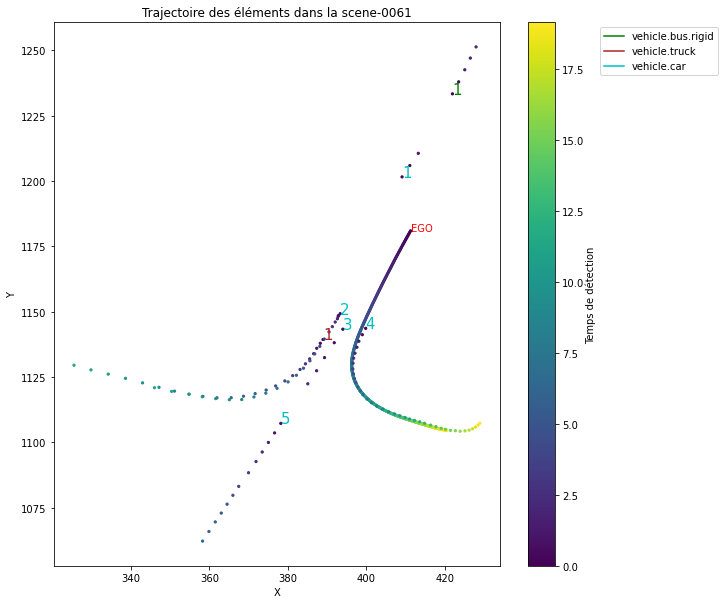

In [20]:
scene_name = 'scene-0061'
traj_ego_veh(scene_name)

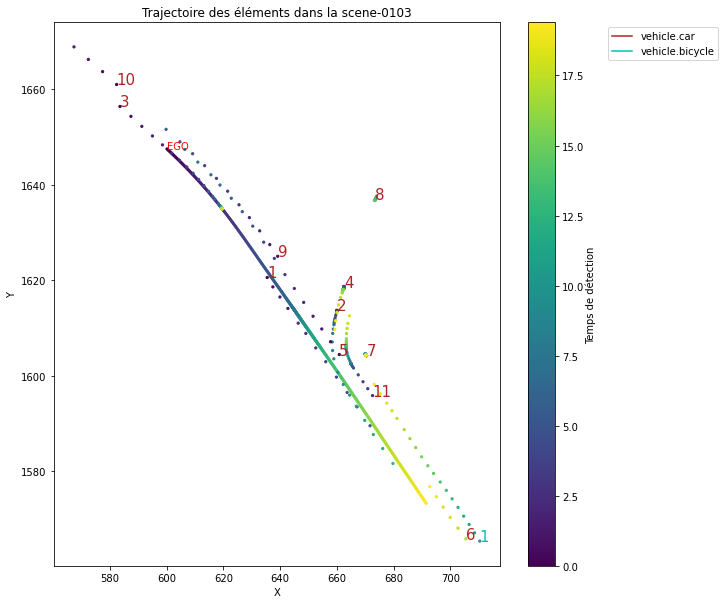

In [21]:
# scene-0103
scene_name = 'scene-0103'
traj_ego_veh(scene_name)

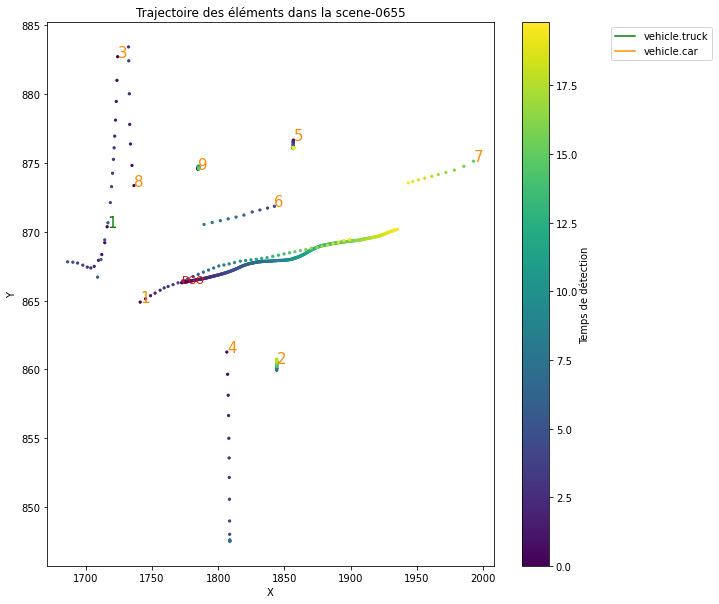

In [22]:
# scene-0655
scene_name = 'scene-0655'
traj_ego_veh(scene_name)

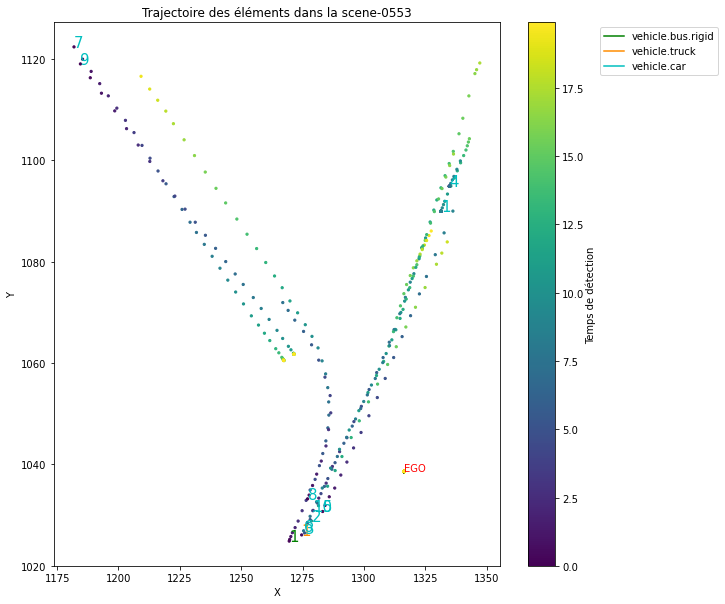

In [23]:
# scene-0553
scene_name = 'scene-0553'
traj_ego_veh(scene_name)

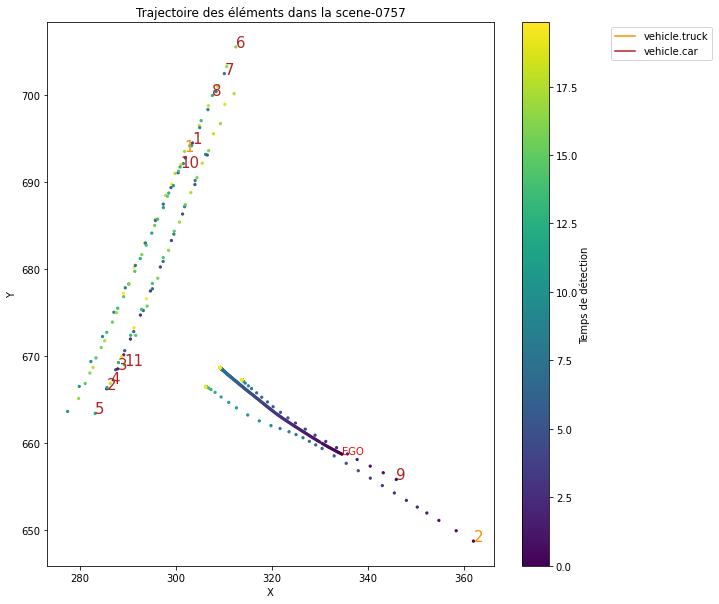

In [24]:
# scene-0757
scene_name = 'scene-0757'
traj_ego_veh(scene_name)

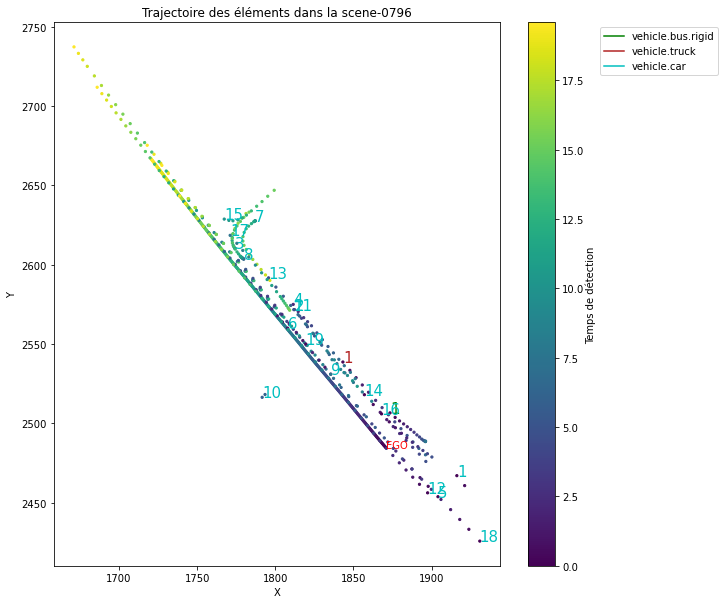

In [25]:
# scene-0796
scene_name = 'scene-0796'
traj_ego_veh(scene_name)

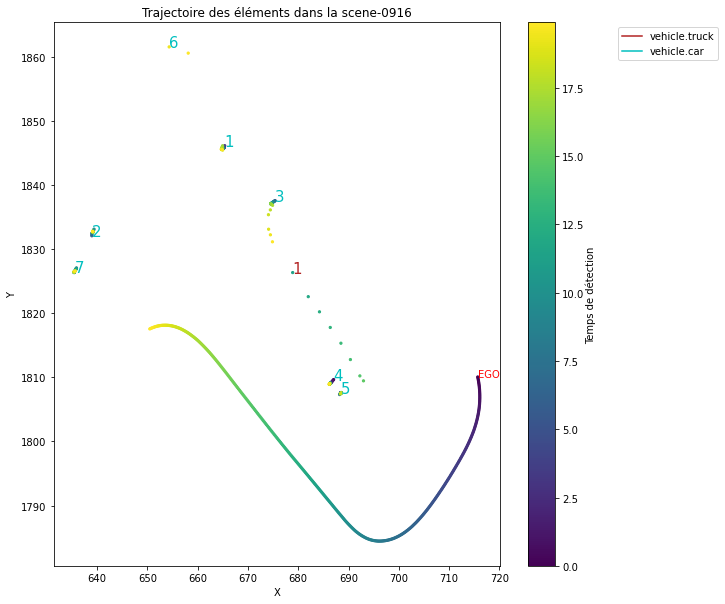

In [26]:
# scene-0916
scene_name = 'scene-0916'
traj_ego_veh(scene_name)

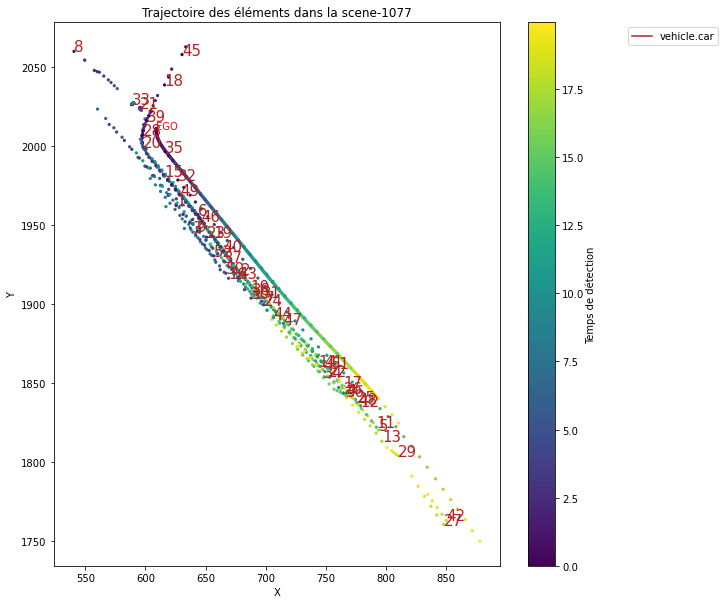

In [27]:
# scene-1077
scene_name = 'scene-1077'
traj_ego_veh(scene_name)

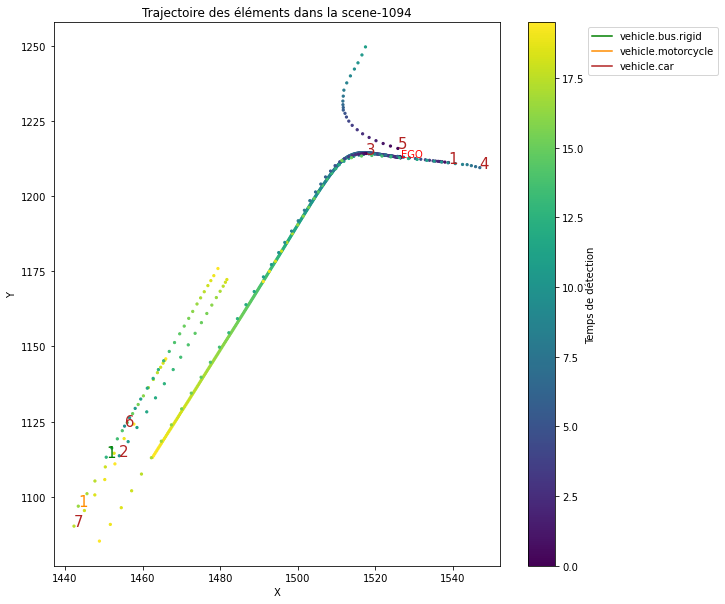

In [28]:
# scene-1094
scene_name = 'scene-1094'
traj_ego_veh(scene_name)

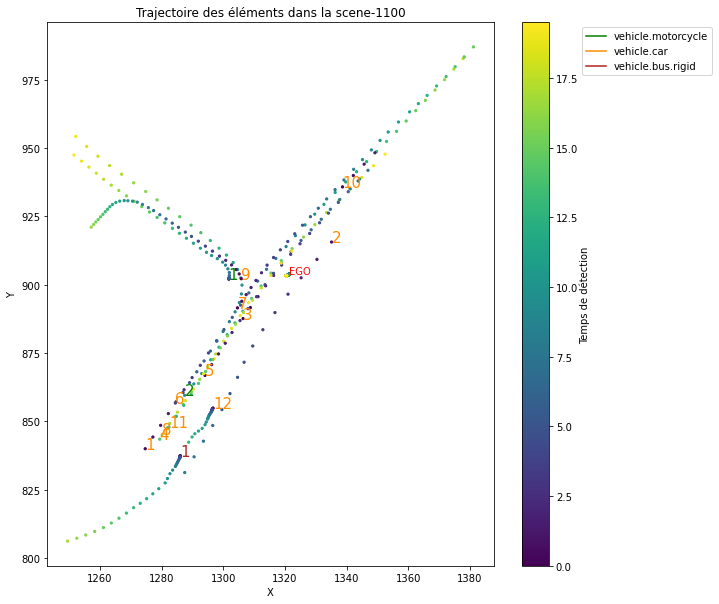

In [29]:
# scene-1100
scene_name = 'scene-1100'
traj_ego_veh(scene_name)

In [30]:
### On conserve uniquement quelques couples en car following 
L_Cfollowing = ['vehicle.car 4/ego dans scene-0061','vehicle.car 2 /vehicle.truck 1 scene-0061',\
                'vehicle.car 2 /vehicle.car 4 scene-0103','vehicle.car 2 /vehicle.car 3 scene-0757',\
                'vehicle.car 2 /vehicle.car 4 scene-0757','vehicle.car 2 /vehicle.car 5 scene-0757',\
                'vehicle.car 2 /vehicle.car 11 scene-0757','vehicle.car 3 /vehicle.car 4 scene-0757',\
                'vehicle.car 3 /vehicle.car 5 scene-0757','vehicle.car 3 /vehicle.car 11 scene-0757',\
                'vehicle.car 4 /vehicle.car 5 scene-0757','vehicle.car 4 /vehicle.car 11 scene-0757',\
                'vehicle.car 5 /vehicle.car 11 scene-0757','vehicle.car 1 /vehicle.car 10 scene-0757',\
                'vehicle.car 1 /vehicle.truck 1 scene-0757','vehicle.car 10 /vehicle.truck 1 scene-0757',\
                'vehicle.car 6 /vehicle.car 7 scene-0757','vehicle.car 6 /vehicle.car 8 scene-0757',\
                'vehicle.car 7 /vehicle.car 8 scene-0757','vehicle.car 3/ego dans scene-1094',\
                'vehicle.car 1/ego dans scene-1094','vehicle.car 4/ego dans scene-1094',\
                'vehicle.car 1 /vehicle.car 3 scene-1094','vehicle.car 1 /vehicle.car 4 scene-1094',\
                'vehicle.car 3 /vehicle.car 4 scene-1094','vehicle.car 12/ego dans scene-0796',\
               'vehicle.car 5 /vehicle.car 18 scene-0796','vehicle.car 9 /vehicle.car 19 scene-0796',\
               'vehicle.car 9 /vehicle.car 18 scene-0796','vehicle.car 5 /vehicle.car 9 scene-0796',\
               'vehicle.car 5 /vehicle.car 19 scene-0796','vehicle.car 5 /vehicle.car 6 scene-0796',\
               'vehicle.car 6 /vehicle.car 19 scene-0796','vehicle.car 6 /vehicle.car 9 scene-0796',\
               'vehicle.car 6 /vehicle.car 18 scene-0796']

In [31]:
# On crée une dataframe avec uniquement ces couples
df_CF = DF_finale[DF_finale.index.isin(L_Cfollowing)]
df_CF = df_CF.dropna()
df_CF

,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,4,4.77538,3.222342,1.0,5.050621,14.823187,...,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,1,0.037589,77.803221,25.983685
vehicle.car 12/ego dans scene-0796,scene-0796,vehicle.ego,1,vehicle.car,12,12.089013,12.534988,1.0,3.53724,31.270194,...,0.00988,0.000015,0.045671,0.999926,0.998957,1.0,1,0.032123,275.526881,85.757029
vehicle.car 1/ego dans scene-1094,scene-1094,vehicle.ego,1,vehicle.car,1,6.48147,3.741095,1.0,8.983232,24.412228,...,0.062666,0.000229,0.418811,0.995172,0.908074,1.0,1,0.023122,124.280663,36.295795
vehicle.car 3/ego dans scene-1094,scene-1094,vehicle.ego,1,vehicle.car,3,6.48147,7.599702,1.0,2.623598,18.714144,...,0.095337,0.000356,0.288046,0.989541,0.957617,1.0,1,0.0917,149.473732,49.131097
vehicle.car 4/ego dans scene-1094,scene-1094,vehicle.ego,1,vehicle.car,4,7.4012,4.008208,0.461541,23.451321,38.812647,...,0.40918,0.027009,0.720555,0.880489,0.693398,0.999635,1,0.172484,82.919428,39.433337
vehicle.car 2 /vehicle.truck 1 scene-0061,scene-0061,vehicle.car,2,vehicle.truck,1,5.78235,6.667293,1.0,3.118809,11.123231,...,0.056971,0.00307,0.245053,0.996989,0.96951,0.999995,1,0.034132,70.679595,26.328946
vehicle.car 2 /vehicle.car 3 scene-0757,scene-0757,vehicle.car,2,vehicle.car,3,5.790087,8.233405,0.299977,16.657484,16.754359,...,0.058194,0.058069,0.058331,0.998305,0.998297,0.998313,1,13.09301,34.117646,23.494974
vehicle.car 4 /vehicle.car 11 scene-0757,scene-0757,vehicle.car,4,vehicle.car,11,7.813404,8.259975,0.111184,25.999019,25.999019,...,0.054926,0.054926,0.054926,0.99849,0.99849,0.99849,1,31.984984,40.025773,36.005462
vehicle.car 5 /vehicle.car 11 scene-0757,scene-0757,vehicle.car,5,vehicle.car,11,7.981477,8.045299,0.500088,5.383739,9.378679,...,0.036603,0.036471,0.0368,0.99933,0.999323,0.999335,1,1.389602,38.64022,15.348228
vehicle.car 6 /vehicle.car 8 scene-0757,scene-0757,vehicle.car,6,vehicle.car,8,5.906255,8.116952,0.300145,28.331192,26.814203,...,0.038882,0.038837,0.038974,0.999244,0.99924,0.999246,1,26.321969,47.362299,36.92059


In [32]:
df_CF[list(df_CF.columns[5:])].astype('float').describe()

,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,Distance instantannée minimale,Distance instantannée maximale,TimeLag moyen horizontal,TimeLag moyen vertical,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.000000
mean,9.180147,9.571076,0.675676,16.843101,32.641295,23.635783,44.996933,2.137067,1.801830,0.091568,0.040081,0.174264,0.965502,0.939707,0.988502,1.0,6.560509,158.903772,59.786319
std,3.774538,4.328634,0.345437,16.524096,24.361740,21.524194,31.818218,3.027981,2.399012,0.197845,0.138937,0.243066,0.132750,0.177305,0.054041,0.0,11.771796,123.549243,39.147160
min,3.597858,3.222342,0.111184,2.623598,6.568523,2.498114,9.943343,0.000000,0.000000,0.007215,0.000015,0.008291,0.367142,0.183099,0.740609,1.0,0.023122,34.117646,15.348228
25%,6.193862,7.062394,0.300061,5.217180,15.054963,8.672910,20.463666,0.000000,0.000000,0.015416,0.000385,0.043307,0.996275,0.968962,0.999802,1.0,0.094722,57.420200,26.983262
50%,7.981477,8.233405,0.969389,13.804269,24.412228,15.834712,29.664759,0.000000,0.499281,0.035928,0.002375,0.056794,0.999330,0.998386,0.999997,1.0,0.744390,111.137733,39.433337
75%,12.240178,13.611921,1.000000,23.514051,41.922062,27.985396,65.505258,4.325252,2.499091,0.060430,0.017462,0.247199,0.999780,0.999059,1.000000,1.0,6.296449,255.113139,94.998690
max,15.212191,15.939041,1.000000,76.185828,82.663752,81.623034,123.399237,9.100045,8.548765,0.916478,0.671937,0.983095,0.999967,0.999966,1.000000,1.0,43.170336,395.535062,130.249749


/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:89: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:90: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes wid

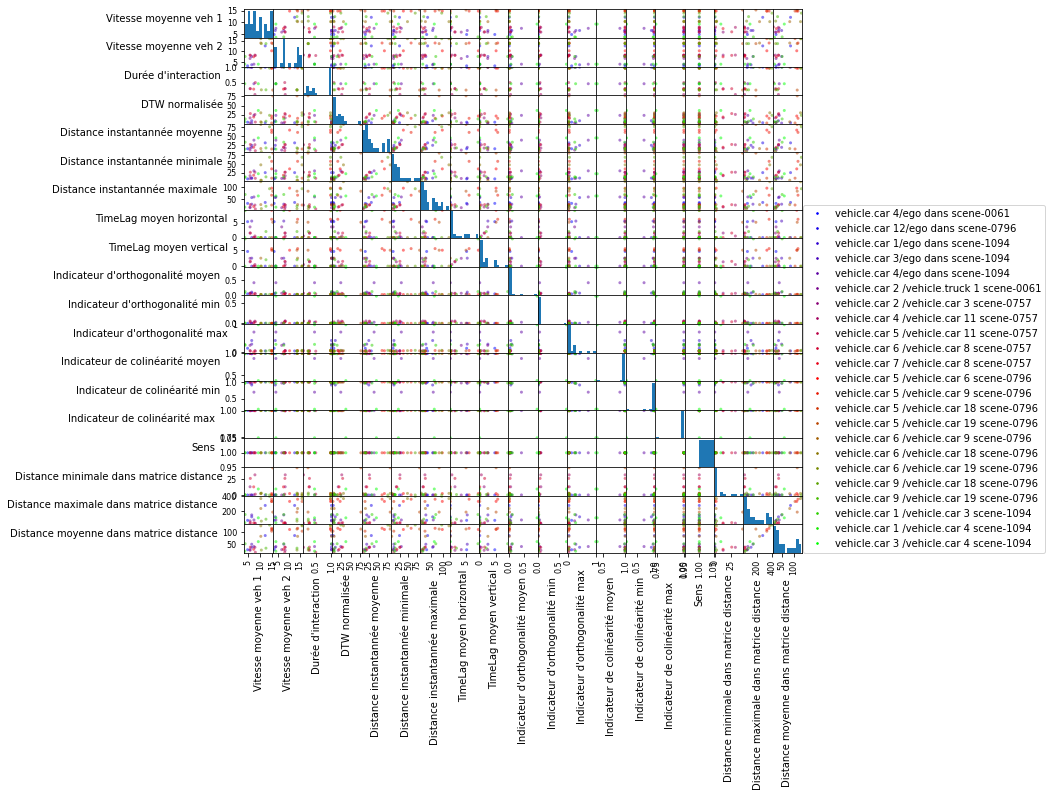

In [33]:
## On va tracer les courbes des colonnes les unes par rapport aux autres, 

# On converti le type des colonnes en float d'abbord
df_CF[list(df_CF.columns[5:])] = df_CF[list(df_CF.columns[5:])].apply(pd.to_numeric)
axes = pd.plotting.scatter_matrix(df_CF,c=[plt.cm.brg(i/(len(df_CF)-1))for i in range(len(df_CF))],label = list(df_CF.index),figsize=(10,10))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

handles = [plt.plot([],[],color=plt.cm.brg(i/(len(df_CF)-1)), ls="", marker=".",markersize=np.sqrt(10))[0] for i in range(len(df_CF))]
labels=list(df_CF.index)
plt.legend(handles, labels, loc=(1.02,0))

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

In [34]:
## On va tracer les headway sur ces couples

In [35]:
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_hd_sp_ego = pd.concat([ego_headway_spatial(scene_name) for scene_name in L_scene_name])
df_hd_sp_entre_veh = pd.concat([headway_spatial_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale_hd_spatial = pd.concat([df_hd_sp_ego,df_hd_sp_entre_veh])

In [36]:
DF_finale_hd_spatial 

,Couple individus,Scene,Timestamp,Temps correspondant,Headway,Vitesse véhicule 1 ou ego,Vitesse véhicule 2
0,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402927647951,0.000000,53.479254,9.135392,9.736836
1,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402928147847,0.499896,62.758010,8.751916,8.847236
2,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402928698048,1.050097,72.383369,8.476892,9.424661
3,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402929197353,1.549402,81.234931,8.277352,9.014914
4,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402929697797,2.049846,89.795179,8.082102,NaN
...,...,...,...,...,...,...,...
1324,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801005447229,17.499530,76.665056,6.531769,11.379594
1325,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801005947122,17.999423,82.614763,6.532070,11.380117
1326,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801006446992,18.499293,88.638423,6.530783,11.378749
1327,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801006946864,18.999165,94.745415,6.530587,11.379730


In [37]:
DF_finale_hd_spatial = DF_finale_hd_spatial[DF_finale_hd_spatial['Couple individus'].isin(L_Cfollowing)]
DF_finale_hd_spatial

,Couple individus,Scene,Timestamp,Temps correspondant,Headway,Vitesse véhicule 1 ou ego,Vitesse véhicule 2
37,vehicle.car 4/ego dans scene-0061,scene-0061,1532402927647951,0.000000,39.030849,9.135392,5.183762
38,vehicle.car 4/ego dans scene-0061,scene-0061,1532402928147847,0.499896,37.134168,8.751916,4.817073
39,vehicle.car 4/ego dans scene-0061,scene-0061,1532402928698048,1.050097,34.975418,8.476892,4.730202
40,vehicle.car 4/ego dans scene-0061,scene-0061,1532402929197353,1.549402,33.162827,8.277352,4.640868
41,vehicle.car 4/ego dans scene-0061,scene-0061,1532402929697797,2.049846,31.412161,8.082102,4.250092
...,...,...,...,...,...,...,...
283,vehicle.car 3 /vehicle.car 4 scene-1094,scene-1094,1542800861447555,13.499436,76.170296,11.092384,5.284845
284,vehicle.car 3 /vehicle.car 4 scene-1094,scene-1094,1542800861947962,13.999843,80.438255,11.033500,5.285069
285,vehicle.car 3 /vehicle.car 4 scene-1094,scene-1094,1542800862447900,14.499781,84.455503,11.756491,5.284853
286,vehicle.car 3 /vehicle.car 4 scene-1094,scene-1094,1542800862947705,14.999586,88.601320,11.581683,5.284896


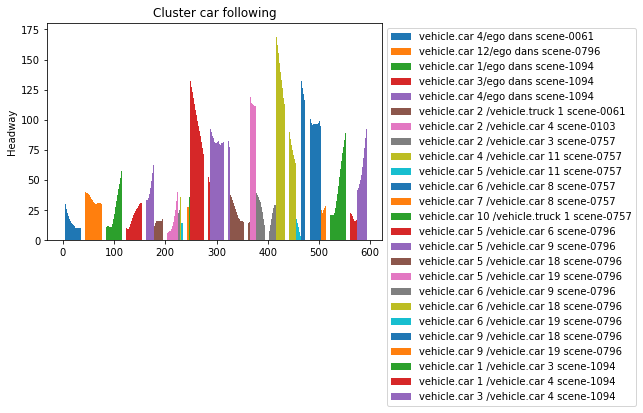

In [38]:
DF = DF_finale_hd_spatial[['Couple individus','Headway']]#.plot.bar()
DF.groupby('Couple individus')
DF = DF.reset_index(drop=True)
L = list(DF['Couple individus'].unique())
plt.figure()
for j in range(0,len(L)):
    a = DF[DF['Couple individus']==L[j]]
    plt.bar(a.index,a['Headway'])
plt.legend(L,bbox_to_anchor=(1, 1.0),loc='best')
plt.ylabel('Headway (en m)')
plt.title('Cluster car following')
plt.show()

In [39]:
## On regarde ce que ça donne avec le clustering auto 

def labelling_auto_dbscan(df):
    
    df_sortante = pd.DataFrame() # La df qu'on va renvoyer 
    
    # ON supprime les Nan de la df
    df = df.dropna()
    
    # Les individus 
    L_indiv = list(df.index)
    df_sortante['Individus'] = L_indiv 
    
    # Préparation des liste pour la df_sortante 
    L_ortho = []
    L_sens = []
    L_distance = []
    L_retard = []
    
    # Quantile pour la DTW 
    quantile_30_DTW = df['DTW normalisée'].quantile(0.3)
    quantile_70_DTW = df['DTW normalisée'].quantile(0.7)
    # Quantile pour timelag
    quantile_30_retard = df['TimeLag moyen vertical'].quantile(0.3)
    quantile_70_retard = df['TimeLag moyen vertical'].quantile(0.7)

    # Boucle sur chaque indiv 
    for i in range(0,len(L_indiv)):
        
        Ligne = df.iloc[i:i+1]

        if Ligne["Durée d'interaction"][0]<=0.1:
            L_ortho.append('Inclassable')
            L_sens.append('Inclassable')
            L_distance.append('Inclassable')
            L_retard.append('Inclassable')
            
        else : 
            # Critère d'orthogonalité 
            if Ligne["Indicateur d'orthogonalité moyen"][0]>=0.8 :
                L_ortho.append('Orthogonale')
            elif 0.2 < Ligne["Indicateur d'orthogonalité moyen"][0]<0.8 :
                L_ortho.append('Variable')
            else : 
                L_ortho.append('Colinéaire')
            
            # Critère de sens 
            if Ligne['Sens'][0]==1:
                L_sens.append('Même sens')
            else :
                if L_ortho[-1]=='Orthogonale':
                    L_sens.append('Orthogonale')
                elif L_ortho[-1]=='Variable':
                    L_sens.append('Variable')
                else : 
                    L_sens.append('Sens inverse')
            
            # Critère de distance 
            if Ligne["DTW normalisée"][0]<= quantile_30_DTW:
                L_distance.append('Petite')
            elif quantile_30_DTW < Ligne["DTW normalisée"][0] <= quantile_70_DTW:
                L_distance.append('Moyenne')
            else : 
                L_distance.append('Grande')
                
            #Critère de retard 
            if Ligne["TimeLag moyen vertical"][0]<= quantile_30_retard:
                L_retard.append('Petit')
            elif quantile_30_retard < Ligne["TimeLag moyen vertical"][0] <= quantile_70_retard:
                L_retard.append('Moyen')
            else : 
                L_retard.append('Grand')
        
    df_sortante['Orthogonalité'] = L_ortho
    df_sortante['Sens'] = L_sens
    df_sortante['DTW'] = L_distance
    df_sortante['Retard'] = L_retard
    df_sortante['Concatenation'] = [L_ortho[k]+' '+L_sens[k]+' '+L_distance[k]+' '+L_retard[k] for k in range(len(L_ortho))]
    
    return df_sortante

In [40]:
classe_auto = labelling_auto_dbscan(df_CF)
classe_auto

,Individus,Orthogonalité,Sens,DTW,Retard,Concatenation
0,vehicle.car 4/ego dans scene-0061,Colinéaire,Même sens,Petite,Grand,Colinéaire Même sens Petite Grand
1,vehicle.car 12/ego dans scene-0796,Colinéaire,Même sens,Petite,Petit,Colinéaire Même sens Petite Petit
2,vehicle.car 1/ego dans scene-1094,Colinéaire,Même sens,Moyenne,Petit,Colinéaire Même sens Moyenne Petit
3,vehicle.car 3/ego dans scene-1094,Colinéaire,Même sens,Petite,Grand,Colinéaire Même sens Petite Grand
4,vehicle.car 4/ego dans scene-1094,Variable,Même sens,Grande,Petit,Variable Même sens Grande Petit
5,vehicle.car 2 /vehicle.truck 1 scene-0061,Colinéaire,Même sens,Petite,Moyen,Colinéaire Même sens Petite Moyen
6,vehicle.car 2 /vehicle.car 3 scene-0757,Colinéaire,Même sens,Moyenne,Moyen,Colinéaire Même sens Moyenne Moyen
7,vehicle.car 4 /vehicle.car 11 scene-0757,Colinéaire,Même sens,Grande,Moyen,Colinéaire Même sens Grande Moyen
8,vehicle.car 5 /vehicle.car 11 scene-0757,Colinéaire,Même sens,Petite,Petit,Colinéaire Même sens Petite Petit
9,vehicle.car 6 /vehicle.car 8 scene-0757,Colinéaire,Même sens,Grande,Moyen,Colinéaire Même sens Grande Moyen


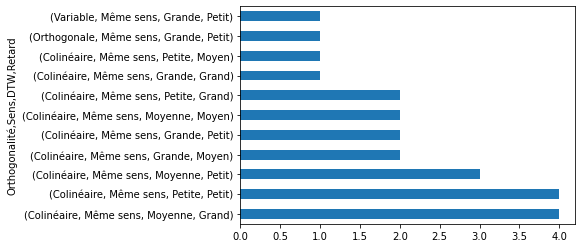

In [41]:
DF = classe_auto[['Orthogonalité','Sens','DTW','Retard']]
if len(DF.value_counts()) !=0:
    DF.value_counts().plot(kind='barh')
    plt.show()

In [42]:
## On regarde s'ils sont aussi dans les mêmes cluster dbscan 

In [43]:
from sklearn.cluster import DBSCAN

def cluster (X,eps, min_samples):
    db= DBSCAN(eps=eps, min_samples=min_samples,algorithm='ball_tree').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels=db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    return labels

In [44]:
# imports nécessaire pour les autres méthodes de clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
DF_finale = DF_finale.dropna()
df_bis = DF_finale.copy()
df_bis[list(df_bis.columns[5:])] = StandardScaler().fit_transform(df_bis[list(df_bis.columns[5:])])
labels_dbscan = cluster (df_bis[list(df_bis.columns[5:])],1.5,2)
DF_finale['Clusters DBscan']=labels_dbscan
DF_finale

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,...,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance,Clusters DBscan
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.bus.rigid,1,8.564618,9.255912,0.107044,62.784244,72.53295,...,0.000274,0.03069,-0.999907,-1.0,-0.999529,0,53.479254,89.795179,71.922482,-1
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,1,8.862925,9.459852,0.054837,24.953401,32.364935,...,0.063754,0.084432,-0.997027,-0.997966,-0.996429,0,20.739661,38.735602,29.578912,0
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,2,6.155384,5.78235,0.600504,15.844434,26.217761,...,0.092346,0.996106,0.831509,0.088161,0.995727,1,6.787707,88.709867,33.192634,1
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,3,8.564618,11.088804,0.107044,32.294648,38.263151,...,0.036886,0.078373,0.99819,0.996924,0.999319,1,23.975892,64.147662,43.973192,2
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,4,4.77538,3.222342,1.0,5.050621,14.823187,...,0.00008,0.140614,0.998951,0.990065,1.0,1,0.037589,77.803221,25.983685,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.car 12 scene-1100,scene-1100,vehicle.car,11,vehicle.car,12,9.349482,3.690104,0.076904,8.217678,9.876039,...,0.01415,0.109751,-0.996929,-0.9999,-0.993959,0,8.300217,13.584201,10.010283,0
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,1,10.122451,6.338455,0.384567,49.083647,46.260902,...,0.983084,0.999991,0.12377,0.00419,0.183158,1,30.3152,104.29712,64.656899,66
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,2,10.122451,11.181889,0.750012,12.551868,29.181995,...,0.001593,0.041305,0.999805,0.999147,0.999999,1,0.49852,122.125142,46.623162,2
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,2,3.024676,10.319906,0.269163,22.700355,22.612802,...,0.014357,0.248427,-0.981828,-0.999897,-0.968651,0,11.473515,51.084325,28.863618,-1


In [45]:
# Cluster DBSCAN des éléments de la classe car following 
DF_finale[DF_finale.index.isin(L_Cfollowing)]['Clusters DBscan'] 

vehicle.car 4/ego dans scene-0061            -1
vehicle.car 12/ego dans scene-0796            7
vehicle.car 1/ego dans scene-1094            -1
vehicle.car 3/ego dans scene-1094             2
vehicle.car 4/ego dans scene-1094            14
vehicle.car 2 /vehicle.truck 1 scene-0061     2
vehicle.car 2 /vehicle.car 3 scene-0757       2
vehicle.car 4 /vehicle.car 11 scene-0757      2
vehicle.car 5 /vehicle.car 11 scene-0757      2
vehicle.car 6 /vehicle.car 8 scene-0757       2
vehicle.car 7 /vehicle.car 8 scene-0757       2
vehicle.car 5 /vehicle.car 6 scene-0796       8
vehicle.car 5 /vehicle.car 9 scene-0796      10
vehicle.car 5 /vehicle.car 18 scene-0796      7
vehicle.car 5 /vehicle.car 19 scene-0796     40
vehicle.car 6 /vehicle.car 9 scene-0796       7
vehicle.car 6 /vehicle.car 18 scene-0796     42
vehicle.car 6 /vehicle.car 19 scene-0796      2
vehicle.car 9 /vehicle.car 18 scene-0796     42
vehicle.car 9 /vehicle.car 19 scene-0796      2
vehicle.car 1 /vehicle.car 3 scene-1094 

In [46]:
# Part des couples en car following dans les classes où ils sont présents 
(DF_finale[DF_finale.index.isin(L_Cfollowing)]['Clusters DBscan'].value_counts()/DF_finale['Clusters DBscan'].value_counts()).dropna()

-1     0.013393
 2     0.018450
 7     0.428571
 8     0.500000
 10    0.500000
 14    0.500000
 32    0.500000
 40    0.500000
 42    0.500000
Name: Clusters DBscan, dtype: float64